In [138]:
%load_ext autoreload
%autoreload 2

import os
from collections import OrderedDict
from collections import defaultdict
from random import randrange


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

import respy as rp
from respy.pre_processing.model_processing import process_params_and_options

from python.auxiliary import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulated Method of Moments estimation

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Model-&amp;-Observed-Data" data-toc-modified-id="Model-&amp;-Observed-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Model &amp; Observed Data</a></span></li><li><span><a href="#Setup-for-SMM-Estimation" data-toc-modified-id="Setup-for-SMM-Estimation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup for SMM Estimation</a></span><ul class="toc-item"><li><span><a href="#Calculate-Moments" data-toc-modified-id="Calculate-Moments-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Calculate Moments</a></span><ul class="toc-item"><li><span><a href="#Function-for-calculating-moments" data-toc-modified-id="Function-for-calculating-moments-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Function for calculating moments</a></span></li><li><span><a href="#Observed-Moments" data-toc-modified-id="Observed-Moments-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Observed Moments</a></span></li></ul></li><li><span><a href="#Weighting-Matrix" data-toc-modified-id="Weighting-Matrix-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Weighting-Matrix</a></span></li><li><span><a href="#Criterion-Function" data-toc-modified-id="Criterion-Function-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Criterion Function</a></span></li></ul></li><li><span><a href="#SMM-Estimation" data-toc-modified-id="SMM-Estimation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>SMM Estimation</a></span><ul class="toc-item"><li><span><a href="#Define-starting-paramters" data-toc-modified-id="Define-starting-paramters-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Define starting paramters</a></span></li><li><span><a href="#Simulated-Moments" data-toc-modified-id="Simulated-Moments-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Simulated Moments</a></span></li><li><span><a href="#Optimization-proceidure" data-toc-modified-id="Optimization-proceidure-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Optimization proceidure</a></span><ul class="toc-item"><li><span><a href="#Upper-and-Lower-Bounds" data-toc-modified-id="Upper-and-Lower-Bounds-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Upper and Lower Bounds</a></span></li><li><span><a href="#Constraints" data-toc-modified-id="Constraints-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Constraints</a></span></li><li><span><a href="#Optimize" data-toc-modified-id="Optimize-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Optimize</a></span></li><li><span><a href="#Plot-Criterion-Function" data-toc-modified-id="Plot-Criterion-Function-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Plot Criterion Function</a></span></li></ul></li></ul></li><li><span><a href="#Simulation-Study" data-toc-modified-id="Simulation-Study-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Simulation Study</a></span><ul class="toc-item"><li><span><a href="#Changing-the-Simulation-Seed" data-toc-modified-id="Changing-the-Simulation-Seed-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Changing the Simulation Seed</a></span></li></ul></li></ul></div>

To Do:
 - [ ] Add Weighting Matrix (Sec. 3)
 - [ ] Add explanations for criterion function (Sec. 4)
 - [ ] Add wrapper for criterion function (Sec. 4)
 - [ ] Rework code for plots to hide specifications in auxiliary file (Sec. 4)
 - [ ] Remove custom formatting from plots (Sec. 4)
 - [ ] Add outline to estimation (Sec. 5)
 - [ ] Add explanation to all parts of monte carlo exercise (Sec. 5.2-5.5)
 - [ ] Add references


##  Observed Data

Our model and data is given by [respy](https://respy.readthedocs.io/en/latest/)'s `robinson` example model. In this simple model, the agent, Robinson Crusoe, in each time period decides between two choice options: working (i.e. going fishing) or spending time in the hammock. We use the function `get_example_model `to simulate the model and a dataset.

For the remainder of this notebook we will treat these observations as though they are real observed data and try to recover the parameters of the model using this data. However, since this is actually a simulated model for which we know the true parameter vector, we will be able to compare how well our estimation procedures perform.

In [115]:
#options_base = yaml.safe_load(open(os.environ["ROBINSON_SPEC"] + '/robinson.yaml', 'r'))

#params_base = pd.read_csv(open(os.environ["ROBINSON_SPEC"] + '/robinson.csv', 'r'))
#params_base.set_index(["category", "name"], inplace=True)

#simulate = rp.get_simulate_func(params_base, options_base)
#df = simulate(params_base)

In [116]:
params_true, options, data_obs = rp.get_example_model("robinson", with_data=True)

Let's take a look at the model specifications.

In [117]:
params_true 

value
category       name                       
delta          delta                 0.950
wage_fishing   exp_fishing           0.070
nonpec_fishing constant             -0.100
nonpec_hammock constant              1.046
shocks_sdcorr  sd_fishing            0.010
               sd_hammock            0.010
               corr_hammock_fishing  0.000

In [128]:
options

{'estimation_draws': 100,
 'estimation_seed': 100,
 'estimation_tau': 0.001,
 'interpolation_points': -1,
 'n_periods': 5,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'solution_draws': 100,
 'solution_seed': 456,
 'covariates': {'constant': '1'}}

In [119]:
data_obs.head(10)

,Identifier,Period,Choice,Wage,Experience_Fishing,Type,Nonpecuniary_Reward_Fishing,Nonpecuniary_Reward_Hammock,Wage_Fishing,Flow_Utility_Fishing,Flow_Utility_Hammock,Value_Function_Fishing,Value_Function_Hammock,Shock_Reward_Fishing,Shock_Reward_Hammock,Discount_Rate
0,0,0,fishing,1.007197,0,0,-0.1,1.046,1.000000,0.907197,1.056305,4.747093,4.744600,1.007197,0.010305,0.95
1,0,1,fishing,1.082581,1,0,-0.1,1.046,1.072508,0.982581,1.046042,4.050283,3.892430,1.009392,0.000042,0.95
2,0,2,fishing,1.163836,2,0,-0.1,1.046,1.150274,1.063836,1.053231,3.244500,3.073945,1.011790,0.007231,0.95
3,0,3,fishing,1.239123,3,0,-0.1,1.046,1.233678,1.139123,1.048698,2.301106,2.125701,1.004414,0.002698,0.95
4,0,4,fishing,1.292003,4,0,-0.1,1.046,1.323130,1.192003,1.030870,1.192003,1.030870,0.976475,-0.015130,0.95
5,1,0,hammock,NaN,0,0,-0.1,1.046,1.000000,0.881015,1.056596,4.720911,4.744891,0.981015,0.010596,0.95
6,1,1,hammock,NaN,0,0,-0.1,1.046,1.000000,0.921590,1.039141,3.767979,3.877250,1.021590,-0.006859,0.95
7,1,2,hammock,NaN,0,0,-0.1,1.046,1.000000,0.899238,1.052078,2.839895,2.992736,0.999238,0.006078,0.95
8,1,3,hammock,NaN,0,0,-0.1,1.046,1.000000,0.893793,1.038037,1.889801,2.034046,0.993793,-0.007963,0.95
9,1,4,hammock,NaN,0,0,-0.1,1.046,1.000000,0.912283,1.052177,0.912283,1.052177,1.012283,0.006177,0.95


## Data Moments

For the setup of the estimation we first have to choose a set of moments that we will use to match the observed data and the simulated model. For this model we include two sets of moments: 

1. The first set are Robinson's **choice probabilities** (choice probabilities here refers to the share of agents that have chosen a specific option) for each period. 
2. The second set are moments that characterize the **wage distribution** for each period, i.e. the mean of the wage of all agents that have chosen fishing in a given period and the standard deviation of the wages. 

In addition to the data, we need the complete set of potential choice options for Robinson. Respy lets us extract them from the model parameters and options.

In [120]:
optim_paras = process_params_and_options(params_true, options)[0]
choice_options_robinson = optim_paras["choices"].keys()

Using the observed data and set of choice options, we can calculate the moments.

In [121]:
# Use a function to calculate the data moments.
moments_obs = get_moments(data_obs, choice_options_robinson)
print('Choice Probabilities')
print(moments_obs['Choice Probabilities'])
print('\n Wage Distribution')
print(moments_obs['Wage Distribution'])

Choice Probabilities
{0: [0.631, 0.369], 1: [0.631, 0.369], 2: [0.631, 0.369], 3: [0.631, 0.369], 4: [0.631, 0.369]}

 Wage Distribution
{0: [1.0037950532864608, 0.009222735533113452], 1: [1.0724623646069125, 0.010885774459361966], 2: [1.1506433910875764, 0.01165976621540699], 3: [1.2325871778674606, 0.01188724268886421], 4: [1.3230636324871103, 0.012512007111785479]}


## Weighting-Matrix

Next we specify a weighting matrix.

In [122]:
# I use the identity matrix for now.
num_moments = options['n_periods']*len(choice_options_robinson)*2
identity_matrix = np.eye(num_moments)
print(identity_matrix)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.

## Criterion Function 

Criterion function at the true parameter vector.

In [123]:
fval = evaluate(params_true, options, identity_matrix, moments_obs, choice_options_robinson)
fval

0.0

We can plot the criterion function to examine its behavior around the minimum in more detail. The plots below show the criterion function at varying values of all parameters in the the paramter vector.

In [124]:
params_true

value
category       name                       
delta          delta                 0.950
wage_fishing   exp_fishing           0.070
nonpec_fishing constant             -0.100
nonpec_hammock constant              1.046
shocks_sdcorr  sd_fishing            0.010
               sd_hammock            0.010
               corr_hammock_fishing  0.000

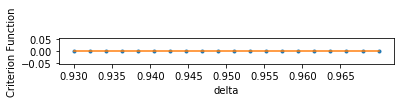

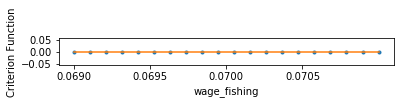

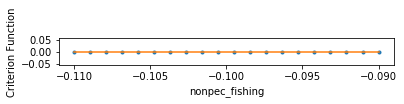

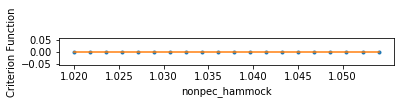

In [ ]:
criterion_args = [options, identity_matrix, moments_obs, choice_options_robinson]
plot_criterion_params(params_true, criterion_args)

This depiction conceals the fact, that the criterion function is not a smooth function of our parameter values. We can reveal this property if we 'zoom into' the function far enough. The plots below show the criterion function for varying values of delta around the true minimum value of 0.95. We can see that the function exhibits small plateaus and is thus not completely smooth. 

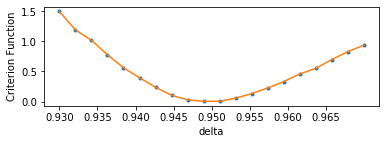

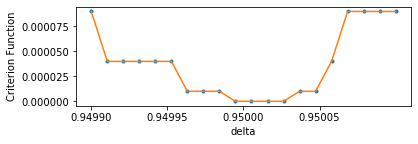

In [139]:
criterion_args = [options, identity_matrix, moments_obs, choice_options_robinson]
plot_criterion_detail(params_true, criterion_args)

##  Estimation Exercise

### Estimation for one parameter

Let's assume now that we do not know the true parameter vector and we seek to estimate it using our observed data. We have already set up the criterion function and the weighting matrix. In the following we will first select parameter vector that differs from the true one as a candidate to begin the estimation with. We will then specify an optimization procedure for our criterion function to try to retrieve the true parameters. 

For now, our candidate parameter vector will just differ in *delta* from the true parameters.

In [48]:
params_cand = params_true.copy()
params_cand.loc['delta','value'] = 0.93

#### Simulated Moments

We can now use our model to simulate data using the candidate parameter vector. We can see that the choice probabilities and wage distribution differ from the moments of the observed dataset.

In [49]:
params = params_cand.copy()
simulate = rp.get_simulate_func(params, options)
df_sim = simulate(params)
moments_sim = get_moments(df_sim, choice_options_robinson)

print('Choice Probabilities')
print(moments_sim['Choice Probabilities'])
print('\n Wage Distribution')
print(moments_sim['Wage Distribution'])

Choice Probabilities
{0: [0.244, 0.756], 1: [0.244, 0.756], 2: [0.244, 0.756], 3: [0.244, 0.756], 4: [0.244, 0.756]}

 Wage Distribution
{0: [1.0095149927160547, 0.008198290003548022], 1: [1.0728957195893678, 0.010514385733230281], 2: [1.1515521441487266, 0.011934344072283899], 3: [1.2330302273612044, 0.011737002476584076], 4: [1.3217938871844948, 0.013266040322672396]}


We can see that the criterion function value for the candidate parameter vector is not zero.

In [50]:
fval = evaluate(params_cand, options, identity_matrix, moments_obs, choice_options_robinson)
fval

1.4977273938311657

#### Optimization procedure

We will now use an optimization procedure to retrieve the true parameter vector. For the optimization we can use [estimagic](https://estimagic.readthedocs.io/en/latest/index.html). For our optimization procedure we need estimagic's `minimize` function.



In [51]:
from estimagic.optimization.optimize import minimize

We have verified above that the criterion function gives a value of 0 for the true parameter vector. Before we try different parameter specifications, we can check whether an optimizer recognizes the true vector as the minimum of our criterion function.

As the code below shows, the optimization algorithm recognizes the true parameter vector as the minimum of the criterion function as it returns a function value of 0 and the true parameter values.

In [52]:
rslt = minimize(criterion=evaluate,
                params=params_true,
                algorithm="nlopt_bobyqa",
                criterion_args=(options, identity_matrix, moments_obs, choice_options_robinson),
               )
rslt[0]

{'fun': 0.0, 'internal_x': [0.95, 0.07, -0.1, 1.046, 0.01, 0.01, 0.0]}

##### Upper and Lower Bounds

We can help the optimizer by specifying bounds for the parameters. Since we know the true parameters in the case of this model, we can just pick upper and lower bounds that are fairly close to the true values of the parameters to aid the optimizer in the search for the optimum. By default, the upper and lower bounds are set to $\infty$ and $-\infty$, so specifying upper and lower bounds substantially reduces the range of parameter values that the optimizer can potentially cover.

For optimization with estimagic, we can specify bounds by adding the columns *'lower'* and *'upper'* to the dataframe that contains the parameter values.

In [53]:
# Lower and upper bound for parameters
params_cand['lower'] = [0.89, 0.066, -0.11, 1.04, 0, 0, 0]
params_cand['upper'] = [0.98, 0.072, -0.095, 1.055, 0.1, 0.1, 0.1]
params_cand

value  lower  upper
category       name                                     
delta          delta                 0.930  0.890  0.980
wage_fishing   exp_fishing           0.070  0.066  0.072
nonpec_fishing constant             -0.100 -0.110 -0.095
nonpec_hammock constant              1.046  1.040  1.055
shocks_sdcorr  sd_fishing            0.010  0.000  0.100
               sd_hammock            0.010  0.000  0.100
               corr_hammock_fishing  0.000  0.000  0.100

##### Constraints
In addition to specifying bounds we can also need to specify constraints for the optimization. Respy's example models already come with a predefined set of constraints.

In [106]:
#constr = rp.get_parameter_constraints("robinson")
#constr

Additionally we for now hold all other parameters fixed to aid the optimizer in finding the optimal value of delta.

In [ ]:
constr += [
    #{"loc": "delta", "type": "fixed", "value": 0.95},
    {"loc": "wage_fishing", "type": "fixed", "value": 0.07},
    {"loc": "nonpec_fishing", "type": "fixed", "value": -0.1},
    {"loc": "nonpec_hammock", "type":"fixed", "value": 1.046},
    {"loc": "shocks_sdcorr", "type": "fixed"},

]
constr

##### Optimize

In [ ]:
rslt = minimize(criterion=evaluate,
                params=params_cand,
                algorithm="nlopt_bobyqa",
                constraints=constr,
                criterion_args=(options,identity_matrix, moments_obs, choice_options_robinson),
               )
rslt[0]

### Estimation of multiple parameters

In [ ]:
params_multi = params_cand.copy()
params_multi.loc['delta', 'value'] = 0.96
params_multi.loc['wage_fishing'] = 0.0705
params_multi.loc[('nonpec_fishing','value')] = -0.097
params_multi.loc[('nonpec_hammock','value')] = 1.049
params_multi.loc[("shocks_sdcorr","sd_fishing"),"value"] = 0.01
params_multi.loc[("shocks_sdcorr","sd_hammock"),"value"] = 0.01
params_multi.loc[("shocks_sdcorr","corr_hammock_fishing"), "value"] = 0

In [ ]:
#Checking choice porportions for given
simulate = rp.get_simulate_func(params_multi, options)
data_sim = simulate(params_multi)
data_sim.Choice.value_counts()

In [ ]:
params_multi

In [ ]:
constr_free_multi = [
    {"loc": "shocks_sdcorr", "type": "sdcorr"}, 
    #{"loc": "delta", "type": "fixed", "value": 0.95},
    #{"loc": "wage_fishing", "type": "fixed", "value": 0.07},
    #{"loc": "nonpec_fishing", "type": "fixed", "value": -0.1},
    #{"loc": "nonpec_hammock", "type":"fixed", "value": 1.046},
    {"loc": ("shocks_sdcorr","sd_fishing"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","sd_hammock"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","corr_hammock_fishing"), "type": "fixed", "value": 0},  
]

rslt_multi = minimize(criterion=evaluate,
                params=params_multi,
                algorithm="nlopt_bobyqa",
                constraints=constr_free_multi,
                criterion_args=(options,identity_matrix, moments_obs, choice_options_robinson),
                #dashboard=True
               )
rslt_multi[0]

In [ ]:
rslt_multi[1]

### Changing the Simulation Seed

In [ ]:
options_new_seed = options.copy()
options_new_seed["simulation_seed"] = 400

rslt_new_seed = minimize(criterion=evaluate,
                    params=params_cand,
                    algorithm="nlopt_bobyqa",
                    constraints=constr,
                    criterion_args=(options_new_seed,identity_matrix, moments_obs, choice_options_robinson),
                    )
rslt_new_seed[0]

In [ ]:
agents_grid = np.round(np.linspace(100, 5000, 20))
options_num_agents = options.copy()
fvals_agents_grid = []

for val in agents_grid:
    options_num_agents['simulation_agents'] = int(val)
    rslt_num_agents  = minimize(criterion=evaluate,
                                params=params_cand,
                                algorithm="nlopt_bobyqa",
                                constraints=constr,
                                criterion_args=(options_num_agents, identity_matrix, moments_obs, choice_options_robinson),
                               )
    
    fvals_agents_grid.append(rslt_num_agents[0]['fun'])

In [ ]:
plt.plot(agents_grid, fvals_agents_grid)
plt.xlabel('Number of Agents')
plt.ylabel('Criterion Function Value')
plt.title('Function Value for increasing Number of Agents with changing Simulation Seeds')

### Fixing one parameter at the wrong value

In [ ]:
params_3 = params_cand.copy()
params_3.loc["delta", "value"] = 0.97
params_3.loc["wage_fishing", "value"] = 0.069

In [ ]:
constr = [
    {"loc": "shocks_sdcorr", "type": "sdcorr"}, 
    #{"loc": "delta", "type": "fixed", "value": 0.95},
    {"loc": "wage_fishing", "type": "fixed", "value": 0.069},
    {"loc": "nonpec_fishing", "type": "fixed", "value": -0.1},     
    {"loc": "nonpec_hammock", "type":"fixed", "value": 1.046},
    {"loc": ("shocks_sdcorr","sd_fishing"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","sd_hammock"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","corr_hammock_fishing"), "type": "fixed", "value": 0},  
]

In [ ]:
simulate = rp.get_simulate_func(params_3, options)
data_sim = simulate(params_3)
data_sim.Choice.value_counts()

In [ ]:
rslt_3 = minimize(criterion=evaluate,
                params=params_3,
                algorithm="nlopt_bobyqa",
                constraints=constr,
                criterion_args=(options,identity_matrix, moments_obs, choice_options_robinson),
               )
rslt_3[0]

### Retrieving the true parameter vector

In [ ]:
params_4 = rslt_3[1][['value','lower','upper']]
params_4

In [ ]:
# Hold all values except the changed parameter fixed 
constr_free_two = [
    {"loc": "shocks_sdcorr", "type": "sdcorr"}, 
    #{"loc": "delta", "type": "fixed", "value": 0.95},
    #{"loc": "wage_fishing", "type": "fixed", "value": 0.07},
    {"loc": "nonpec_fishing", "type": "fixed", "value": -0.1},     
    {"loc": "nonpec_hammock", "type":"fixed", "value": 1.046},
    {"loc": ("shocks_sdcorr","sd_fishing"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","sd_hammock"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","corr_hammock_fishing"), "type": "fixed", "value": 0},  
]

In [ ]:
rslt_4 = minimize(criterion=evaluate,
                params=params_4,
                algorithm="nlopt_bobyqa",
                constraints=constr_free_two,
                criterion_args=(options,identity_matrix, moments_obs, choice_options_robinson),
               )
rslt_4[0]

In [ ]:
deviation = params_true['value'] - rslt_4[1]['value']
deviation